# Stage 4: Compare Binary Model to Mutli Model with Previous Violations History or Prev Violation + Stim Interactions

**Goal**: The goal of this notebook is to see if adding prev violation with interaction terms improves performance on l/r trials in the test set compared to the binary model specificically with animals only in stage 4 and mostly trained.

Similar to the 2023_11_20 notebook but with updated dataset/prev violation taus.

It would be worthwhile to think about extending this notebook such that the binary and multi models can have the same number of features.

I think this might need to be a single notebook on it's own- comparing how well the binary model does with the varying history and interaction regressors (even if the violation trials are dropped).


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from fitting_utils import create_violation_interaction_pairs
from experiment_compare_models import ExperimentCompareModels
from multiclass_logistic_regression import MultiClassLogisticRegression
from binary_logistic_regression import BinaryLogisticRegression
from model_visualizer import ModelVisualizerCompare
from design_matrix_generator import DesignMatrixGeneratorFilteredHistory, DesignMatrixGeneratorInteractions, DesignMatrixGeneratorPsytrack
sns.set_context("talk")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
stg4_animals = [
    "W051",
    "W060",
    "W065",
    "W068",
    "W072",
    "W073",
    "W074",
    "W075",
    "W078",
    "W080",
    "W082",
    "W083",
    "W088",
    "W089",
]

In [8]:
model_config = {
    "b_psytrack_features": {  # MODEL 1- psytrack binary base
        "model_class": BinaryLogisticRegression,
        "model_type": "binary",
        "design_matrix_generator": DesignMatrixGeneratorPsytrack,
        "filter_implementation": {},  # nothing to filter or drop
    },
    "m_psytrack_features": {  # MODEL 2- pystrack multi base
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {"prev_violation": -1},  # no filter & drop column
        "lr_only_eval": True,  # only eval lr trials
    },
    "m_filter_prev_violation": {  # MODEL 3- with filt prev violation history
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorFilteredHistory,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau
        "lr_only_eval": True,  # only eval lr trials
    },
    "m_filter_prev_violation_stim_itrx": {  # MODEL 4- with filt prev violation history and interactions
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"])
        },
        "lr_only_eval": True,  # only eval lr trials
    },
    "m_filter_prev_violation_all_itrx": {  # MODEL 4- with filt prev violation history and interactions
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "filter_implementation": {
            "prev_violation": 1
        },  # filter column with animals tau,
        "design_matrix_generator_args": {
            "interaction_pairs": create_violation_interaction_pairs(
                ["s_a", "s_b", "prev_sound_avg", "prev_correct", "prev_choice"]
            )
        },
        "lr_only_eval": True,  # only eval lr trials
    },
}
params = {
    "animals": stg4_animals,
    "sigmas": [0.07, 0.13, 0.25, 0.5, 1, 2, 4, 8, 16],
    "random_state": 47,
    "null_mode": "binary",
    "eval_train": True,
    "tau_columns": ["prev_violation"],
    "model_config": model_config,
    "min_training_stage": 4,
}

In [9]:
experiment = ExperimentCompareModels(params)
experiment.run()
experiment.save(
    file_name="2024_01_18_stg4_compare_binary_multi_prev_violation_interactions.pkl"
)

returning viol data for ['W051', 'W060', 'W065', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W082', 'W083', 'W088', 'W089']
minimum training stage is  4

 >>>> evaluating animal W051 <<<<

 ***** evaluating model b_psytrack_features w/ sigma 0.07 *****
         Current function value: 21158.174051
         Iterations: 11
         Function evaluations: 80
         Gradient evaluations: 68

 ***** evaluating model b_psytrack_features w/ sigma 0.13 *****
         Current function value: 21321.261403
         Iterations: 9
         Function evaluations: 58
         Gradient evaluations: 46

 ***** evaluating model b_psytrack_features w/ sigma 0.25 *****
         Current function value: 21359.760570
         Iterations: 10
         Function evaluations: 67
         Gradient evaluations: 55

 ***** evaluating model b_psytrack_features w/ sigma 0.5 *****
         Current function value: 21371.177904
         Iterations: 10
         Function evaluations: 73
         Gradient evalu

In [11]:
# Comment out the models you don't want to plot
ORDER = [
    "b_psytrack_features",
    "m_psytrack_features",
    "m_filter_prev_violation",
    "m_filter_prev_violation_stim_itrx",
    "m_filter_prev_violation_all_itrx",
]

mvc = ModelVisualizerCompare(experiment)
df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)

# Sort the DataFrame
df = df.sort_values("model_name")

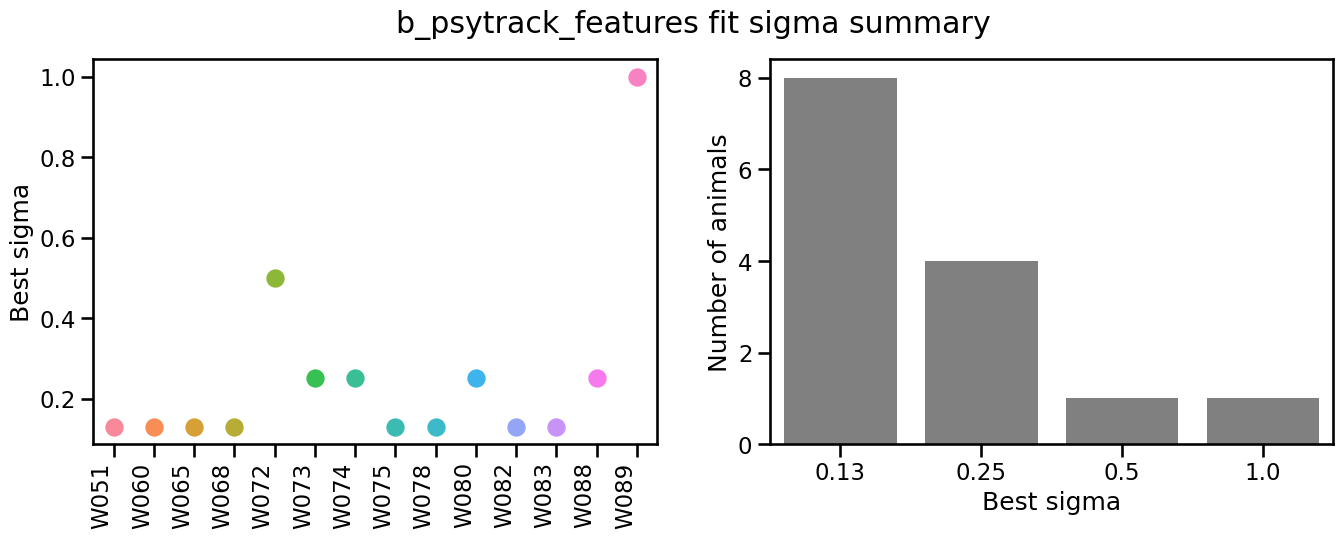

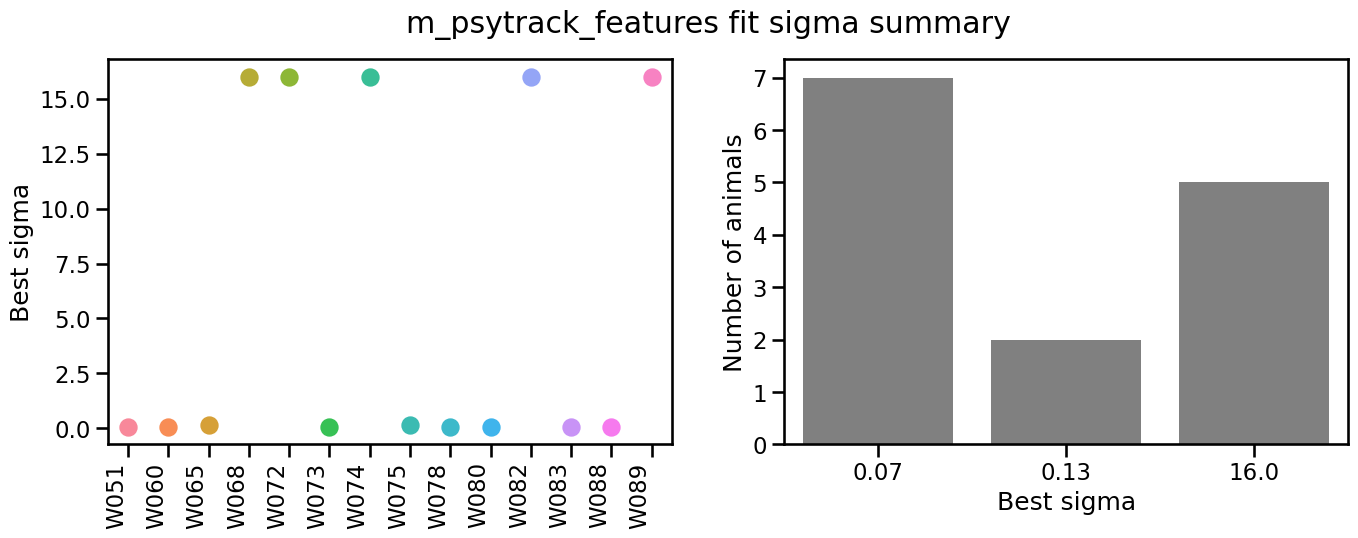

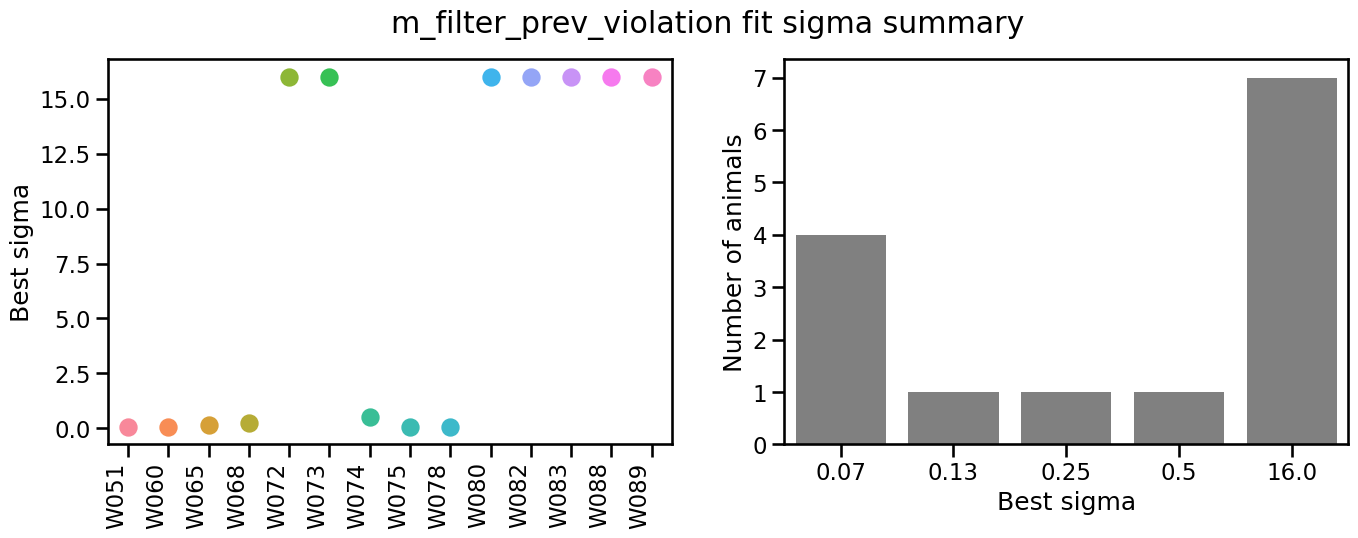

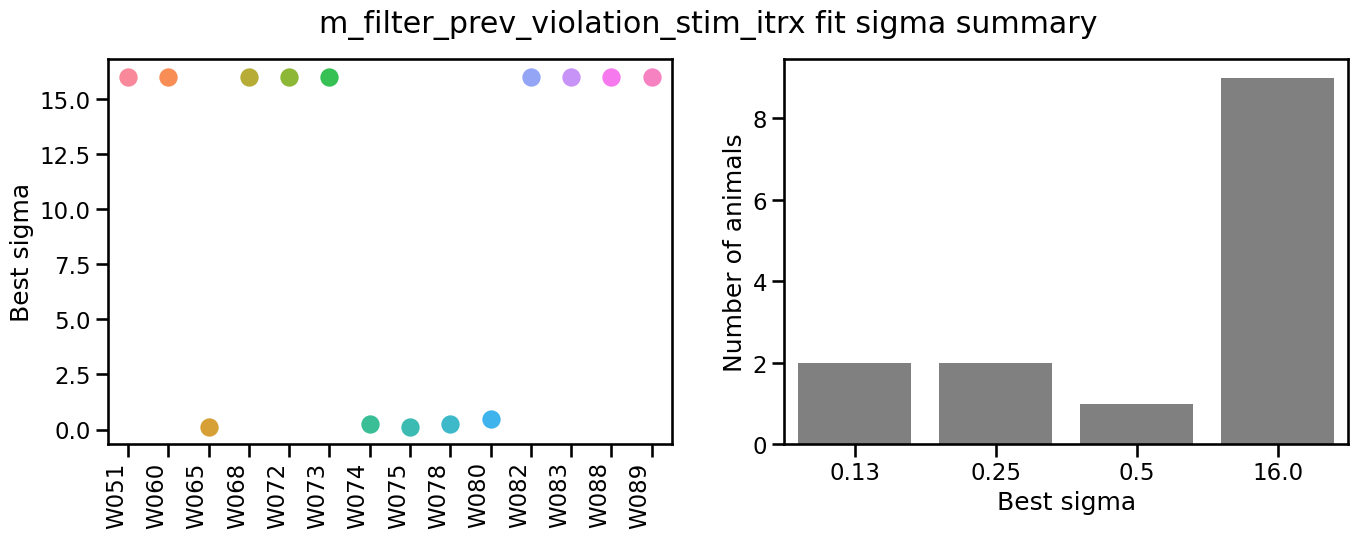

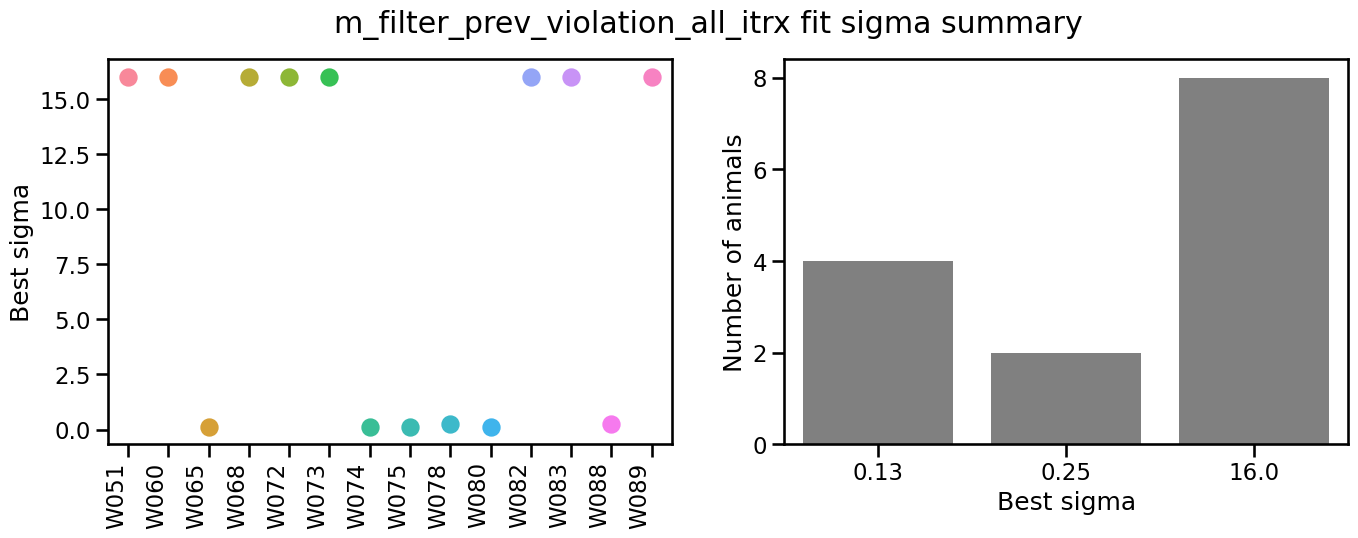

In [12]:
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

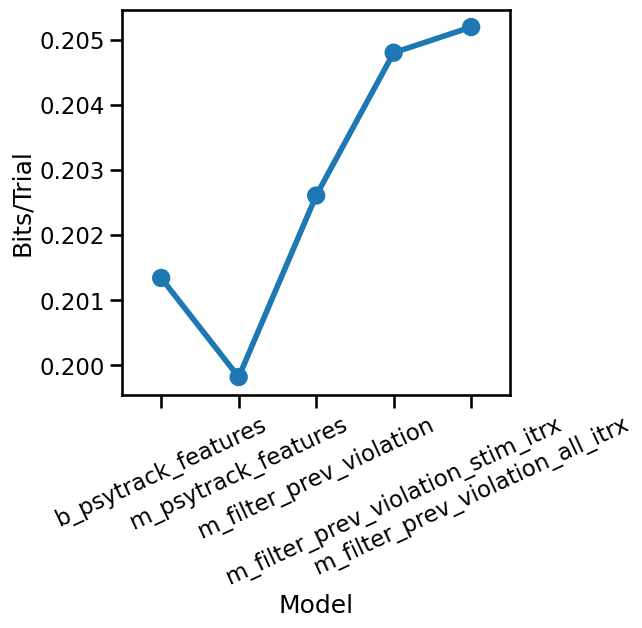

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mvc.plot_model_comparison(hue=None, ax=ax, order=ORDER, errorbar=None)

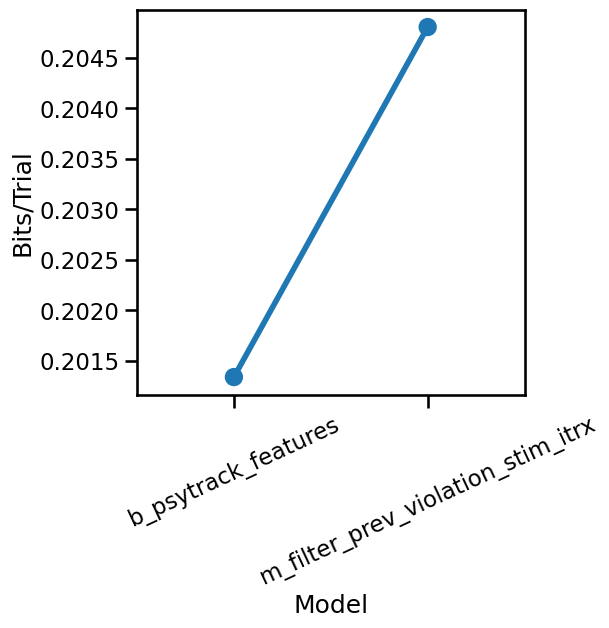

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mvc.plot_model_comparison(hue=None, ax=ax, order=[ORDER[0], ORDER[-2]], errorbar=None)

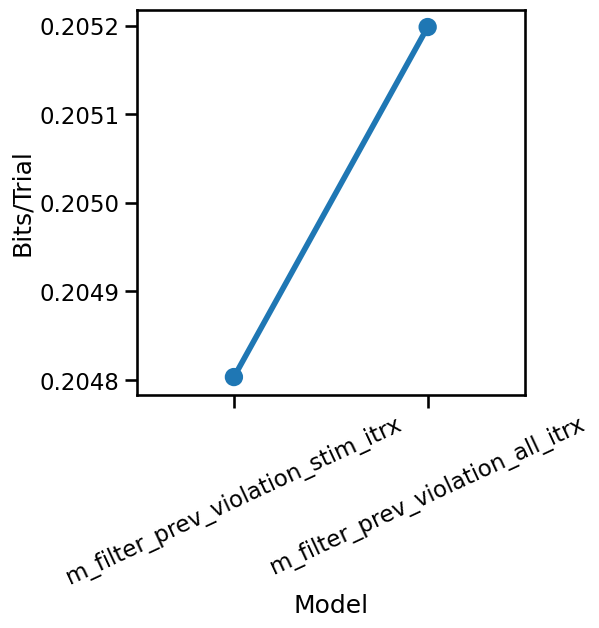

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mvc.plot_model_comparison(hue=None, ax=ax, order=[ORDER[-2], ORDER[-1]], errorbar=None)

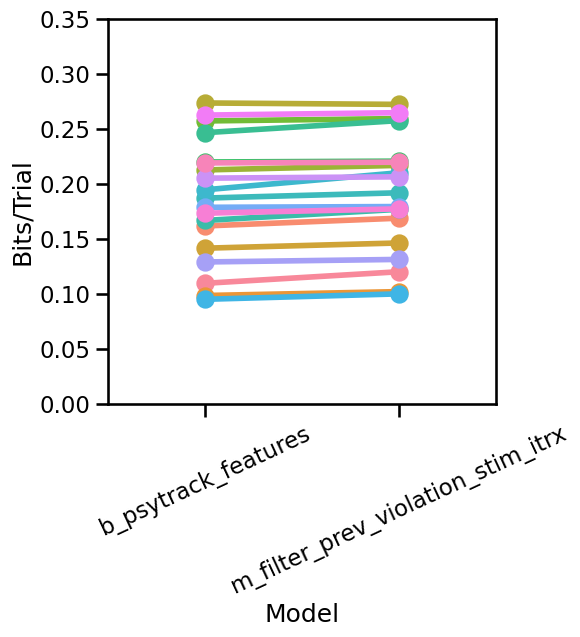

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
mvc.plot_model_comparison(hue="animal_id", ax=ax, order=ORDER)

<Axes: title={'center': 'Model Improvement- mu: 4.24 std: 8.61 \n b_psytrack_features -> m_filter_prev_violation'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

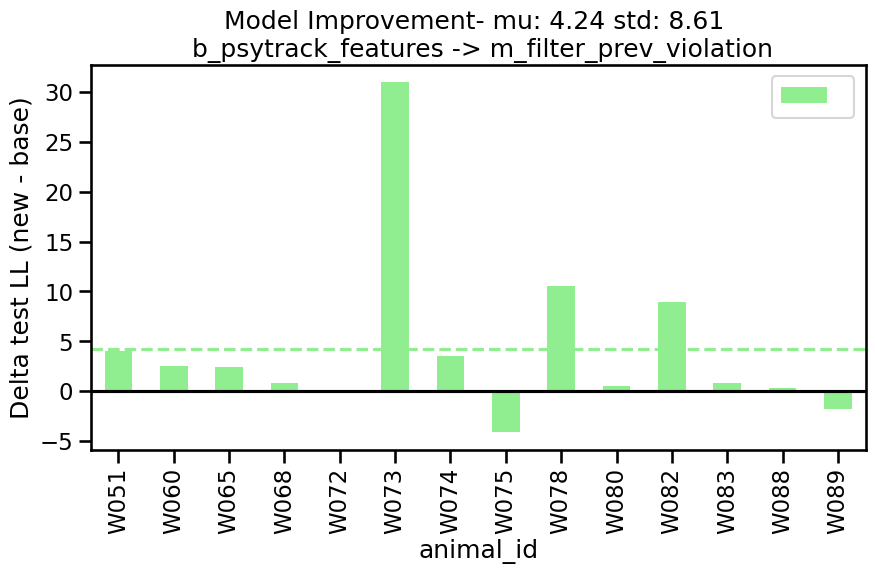

In [24]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[0],
    new_model_name=ORDER[-3],
    type="test",
)

<Axes: title={'center': 'Model Improvement- mu: 12.64 std: 10.82 \n b_psytrack_features -> m_filter_prev_violation_stim_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

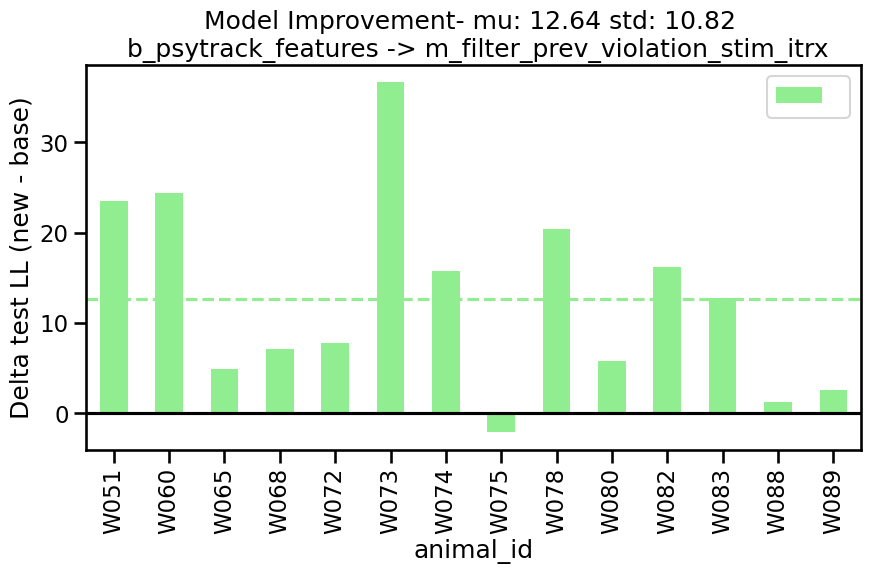

In [25]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[0],
    new_model_name=ORDER[-2],
    type="test",
)

<Axes: title={'center': 'Model Improvement- mu: 2.12 std: 4.91 \n m_filter_prev_violation_stim_itrx -> m_filter_prev_violation_all_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

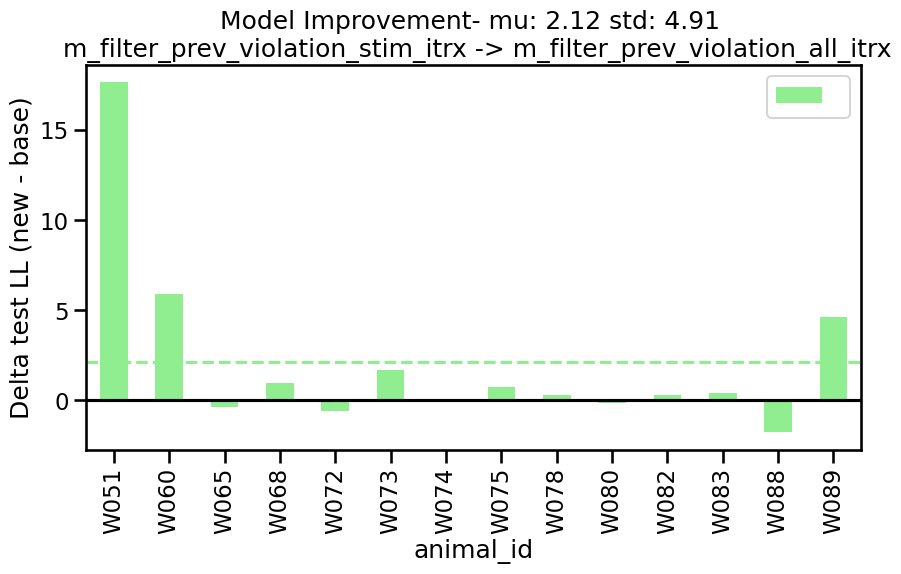

In [26]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[-2],
    new_model_name=ORDER[-1],
    type="test",
)

Because we are adding 3 features to the all interactions model, this plots suggests the improvement is not significant and therefore an interaction model with just the stimulus values (2 new features) is sufficient

<Axes: title={'center': 'Model Improvement- mu: 8.41 std: 6.23 \n m_filter_prev_violation -> m_filter_prev_violation_stim_itrx'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

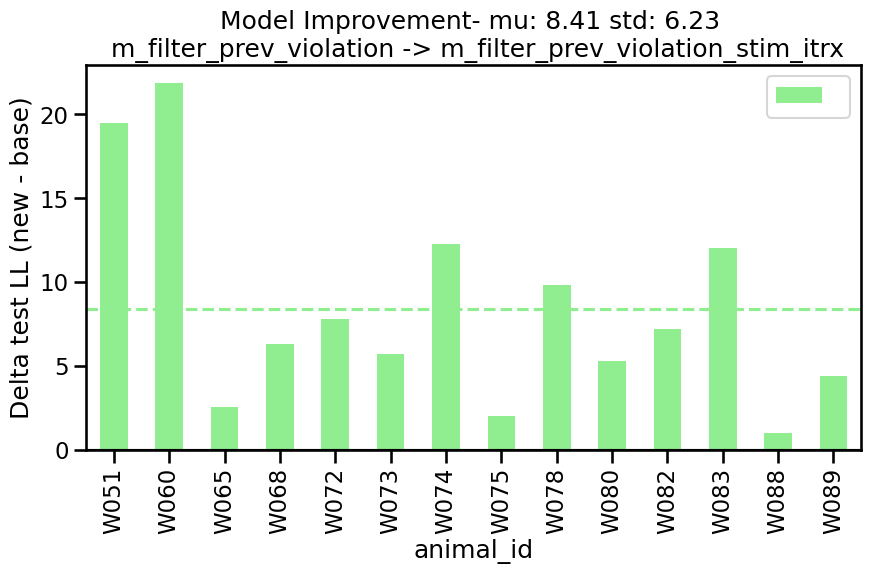

In [27]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[-3],
    new_model_name=ORDER[-2],
    type="test",
)

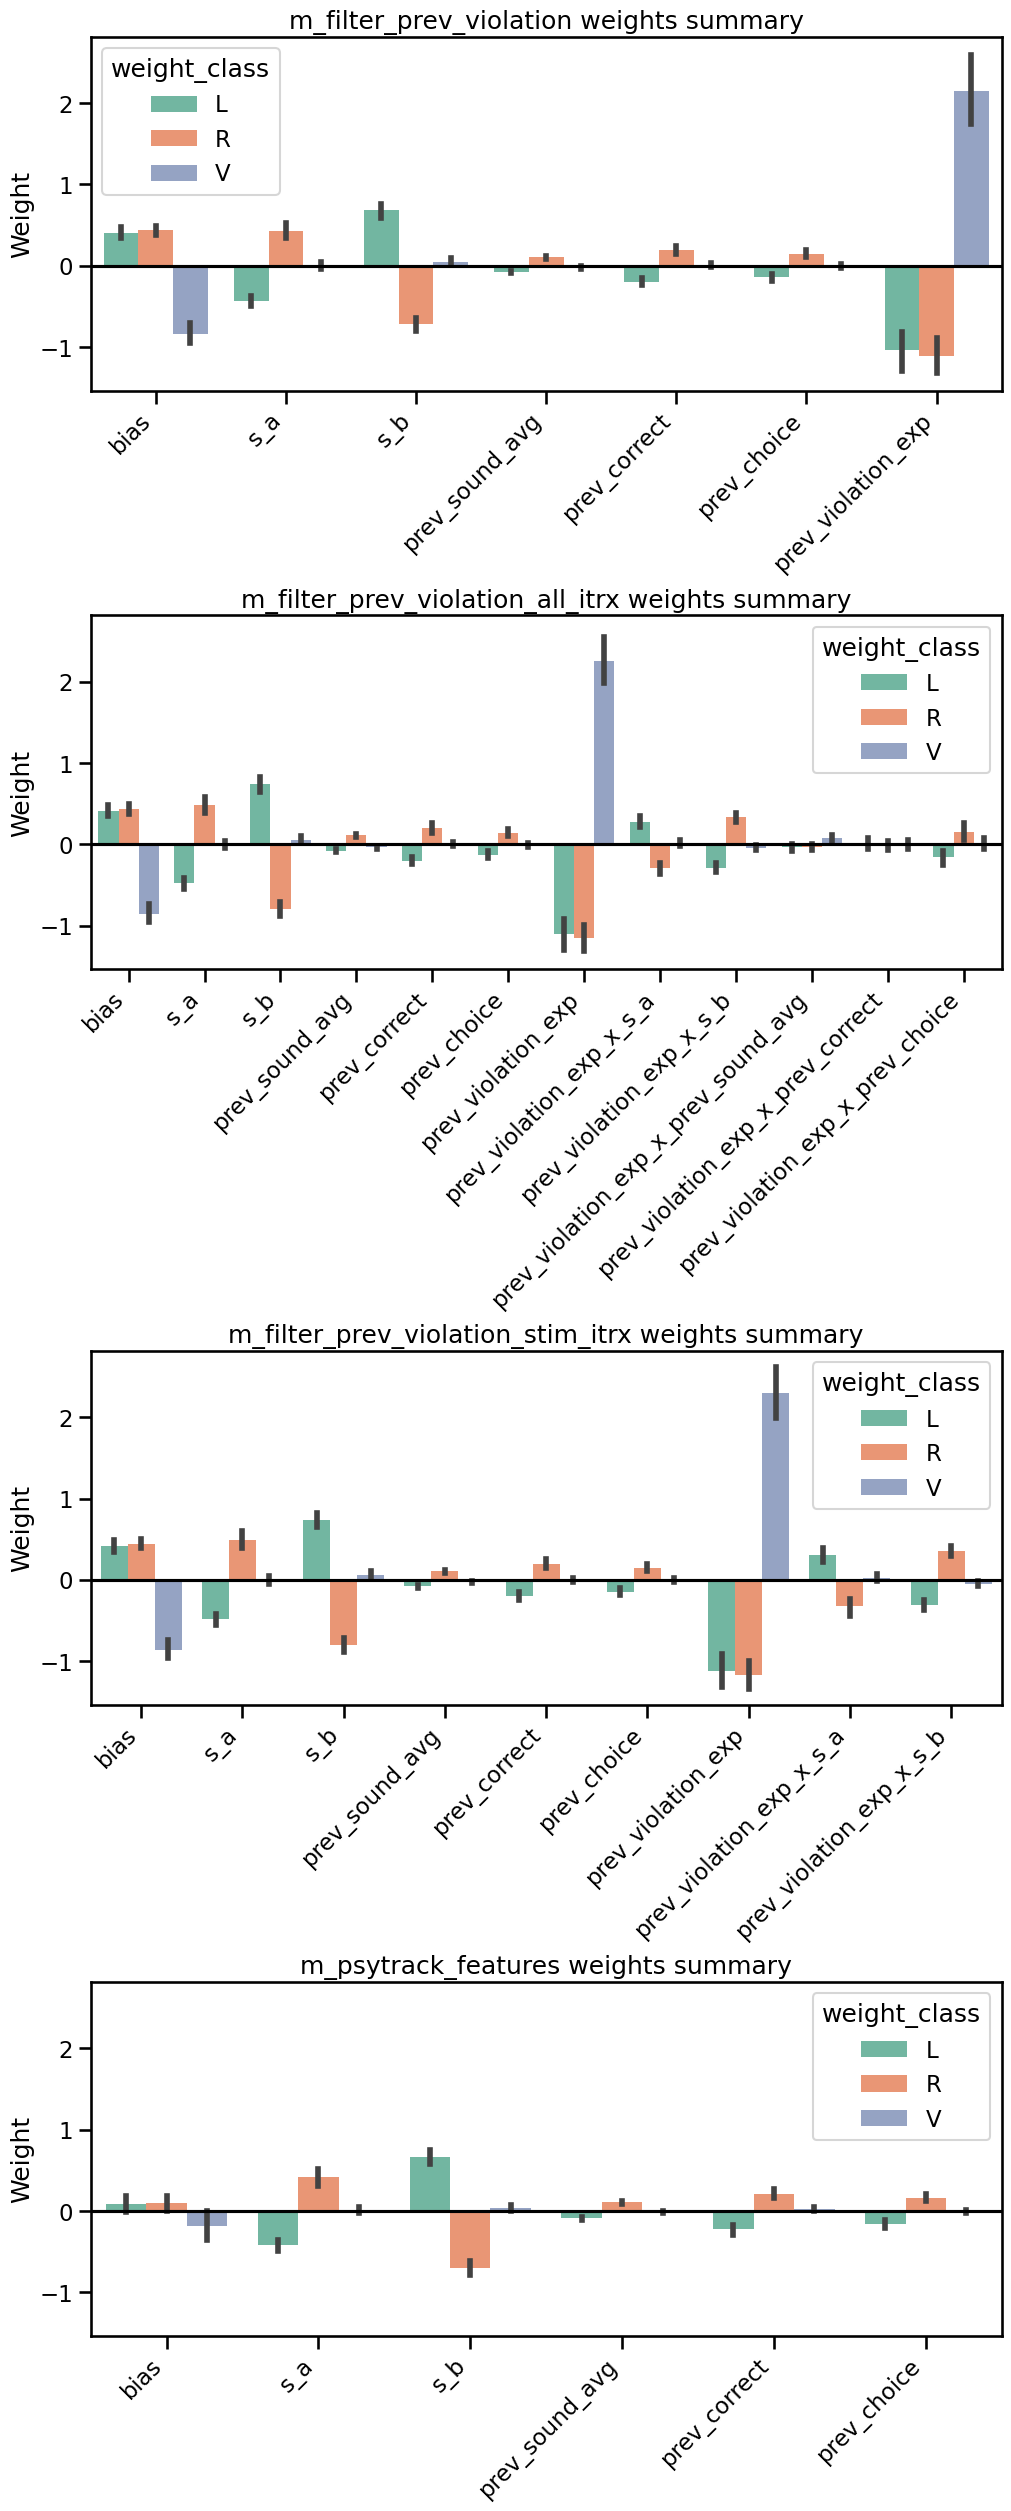

In [31]:
fig, ax = plt.subplots(4, 1, figsize=(10, 25), constrained_layout=True, sharey=True)

best_fit_by_model = mvc.find_best_fit(group=["animal_id", "model_name"])

for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):
    if model_name == ORDER[0]:
        continue
    unpacked = mvc.unpack_features_and_weights(model_df)

    mvc.plot_weights_summary(
        df=unpacked,
        ax=ax[ii - 1],
        palette="Set2",
        title=f"{model_name} weights summary",
    )

**Summary**: Again, results are similar. Some clarity here on interaction terms really only being needed for the violation and stim. Although should keep in mind for future previous choice analysis that this might be important.

The multi-model with interactions does better on L/R trials than the binary model without violation information. Will want to compare this to the binary model with the same regressors. There are three animals where no improvement is seen W075, W088, W089. Looking at the stimulus/interaction weights for these animals and their training status will be clarifying.  